## explore the environment

In [1]:
import gym

env = gym.make('Pong-v0')
obs = env.reset()

In [2]:
obs.shape

(210, 160, 3)

In [3]:
env.action_space

Discrete(6)

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
from IPython import display
%matplotlib inline

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    for f in frames:
        plt.imshow(f)
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [9]:
"""
We see the observation space is a 210x160 RGB image. 
The action space is a Discrete(6) space with 6 different actions: actions 0 and 1 do nothing, actions 2 and 4 move the paddle up, and finally actions 3 and 5 move the paddle down. 
The paddle is free to move immediately but the ball does not appear until after 18 steps into the episode.
"""

# the first argument is a function that takes the curent iteration and produces
# an action for the agent to takethe currentiteration and produce an action
# for the agent to take

def run_episode(policy, n_max_steps=1000, frames_per_action=1):
    obs = env.reset()
    frames = []
    for i in range(n_max_steps):
        obs, reward, done, info = env.step(policy(obs,i))
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
    return frames
    

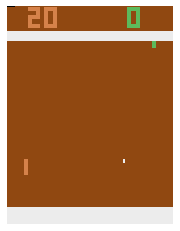

In [10]:
frames = run_episode(lambda obs, i: np.random.randint(0,5))

plot_animation(frames)
# try:
#     run_episode(lambda obs, i: np.random.randint(0,5))
# except Exception as e:
#     print(e)

In [11]:
"""

 let's write a preprocessing function to scale down the input state.
 Since a single observation does not tell us about the ball's velocity, 
 we will also need to combine multiple observations into a single state. 
 Below is the preprocessing code for this environment. 
 The preprocessing algorithm is two-fold:

    Convert the image in the observation to an image to only black and white
    and scale it down to 80x80 pixels.

    Combine 3 observations into a single state which depicts the 
    velocity of the paddles and the ball.

"""

green_paddle_color = (92, 186, 92)
red_paddle_color = (213, 130, 74)
background_color = (144, 72, 17)
ball_color = (236, 236, 236)

def preprocess_observation(obs):
    img = obs[34:194:2, ::2].reshape(-1,3)
    tmp = np.full(shape=(80*80),fill_value=0.0,dtype=np.float32)
    for i, c in enumerate(img):
        c = tuple(c)
        if c in {green_paddle_color, red_paddle_color,ball_color}:
            tmp[i] = 1.0
        else:
            tmp[i] = 0.0
    return tmp.reshape(80, 80)

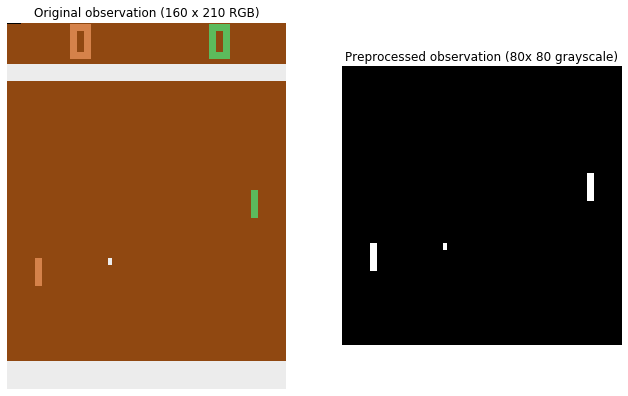

In [12]:
obs = env.reset()
for _ in range(25):
    obs, _,_, _ = env.step(0)

plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title('Original observation (160 x 210 RGB)')
plt.imshow(obs)
plt.axis('off')
plt.subplot(122)
plt.title('Preprocessed observation (80x 80 grayscale)')
plt.imshow(preprocess_observation(obs), interpolation='nearest',cmap='gray')
plt.axis('off')
plt.show()


In [13]:
def combine_observations(preprocess_observations,dim_factor=0.75):
    dimmed = [obs * (dim_factor ** idx)
              for idx, obs in enumerate(reversed(preprocess_observations))]
    return np.max(np.array(dimmed), axis=0)


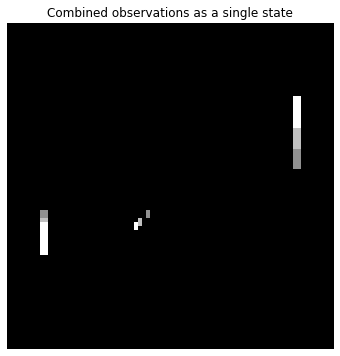

In [14]:
n_observations_per_state = 3

obs = env.reset()
for _ in range(20):
    obs, _, _, _ = env.step(0)

preprocess_observations = []
for _ in range(n_observations_per_state):
    obs, _, _, _ = env.step(2)
    preprocess_observations.append(preprocess_observation(obs))

img = combine_observations(preprocess_observations)

plt.figure(figsize=(6,6))
plt.title('Combined observations as a single state')
plt.imshow(img, interpolation='nearest',cmap='gray')
plt.axis('off')
plt.show()

In [15]:
"""
Now we are going to build the DQN. 
Like the DQN for Pac-Man, 
this model will train 3 convolutional layers,
then a hidden fully connected layer,
then finally a fully connected layer with 6 neurons, 
one representing each possible output
"""

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

input_width = 80
input_height = 80
input_channels = 1

conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [9, 5, 3]
conv_kernel_strides = [4, 2, 1]
conv_paddings = ['VALID'] *3
conv_activation = [tf.nn.relu] * 3

n_hidden_in = 5 * 5 * 64
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n

he_init = tf.contrib.layers.variance_scaling_initializer()


W0701 06:36:03.550806  9840 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [16]:
"""
This model will use two DQNs,
an online DQN and a target DQN. 
The online DQN learns new parameters at each training step.
The target DQN is used to compute the target Q-Values 
for the online DQN's loss function during training. 
The online DQN's parameters are copied to the target
DQN at regular intervals.
"""

def q_network(X_state, name):
    prev_layer = X_state
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_kernel_strides, conv_paddings,
                conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer,filters=n_maps,
                                          kernel_size=kernel_size,
                                          strides=strides,padding=padding,
                                          kernel_initializer=he_init,activation=activation)
        flattened = tf.reshape(prev_layer, [-1, n_hidden_in])
        hidden = tf.layers.dense(flattened, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=he_init)
        outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=he_init)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                         scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]:var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [17]:
# starting DQN definition

X_state = tf.placeholder(tf.float32, shape=(None, input_height, input_width, input_channels))
online_q_values, online_vars = q_network(X_state, 'q_networks/online')
target_q_values, target_vars = q_network(X_state, 'q_networks/target')
copy_ops = [var.assign(online_vars[name]) for name,var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

W0701 06:36:05.777945  9840 deprecation.py:323] From <ipython-input-16-a3fbd879d20f>:20: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0701 06:36:05.778944  9840 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\layers\convolutional.py:424: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0701 06:36:05.829783  9840 deprecation.py:323] From <ipython-input-16-a3fbd879d20f>:24: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


In [18]:
#defining traning objective

learning_rate = 1e-3
momentum = 0.95

with tf.variable_scope('training') as scope:
    X_action = tf.placeholder(tf.int32, shape=(None,))
    y = tf.placeholder(tf.float32, shape=(None, 1))
    Q_target = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                             axis=1, keepdims=True)
    error = tf.abs(y- Q_target)
    loss = tf.reduce_mean(tf.square(error))
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    
    training_op = optimizer.minimize(loss, global_step=global_step)

In [19]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [20]:
"""
This model will sample past experiences from a _Replay Memory_, this will hopefully help the model learn what higher level patterns to pay attention to to find the right action. It also reduces the chance that the model's behavior gets too correlated to it's most recent experiences.

The replay memory will store its data in the kernel's memory.

"""

class ReplayMemory(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length  = 0
    
    def append(self, data):
        self.buf[self.index] = data
        self.index += 1
        self.index %= self.maxlen
        self.length = min(self.length + 1, self.maxlen)
    
    def sample(self, batch_size):
        return self.buf[np.random.randint(self.length, size=batch_size)]

In [21]:
replay_size = 200000
replay_memory = ReplayMemory(replay_size)

In [22]:
def sample_memories(batch_size):
    cols = [[], [], [], []]
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1,1), cols[3], cols[4].reshape(-1,1)

In [23]:
"""
Now let's define the model's policy during training. 
Just like in MsPacMan.ipynb, we will use an 𝜀-greedy policy.
"""

eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 6000000

def epsilon_greedy(q_values, step):
    epsilon = min(eps_min,
                  eps_max- ((eps_max - eps_min) * (step/eps_decay_steps)))
    if np.random.random() < epsilon:
        return np.random.randint(n_outputs)
    return np.argmax(q_values)

In [24]:
"""
Now we will train the model to play some Pong.
The model will input an action once every 3 frames.
The preprocessing functions defined above will use the 3 frames 
to compute the state the model will use to 
"""

n_steps = 10000000
training_start = 100000
training_interval = 4
save_steps = 1000
copy_steps = 10000
dsicount_rate =0.95
skip_start = 20
batch_size =50
iteration = 0
done = True
# to reset the environment at the start

loss_val = np.infty
game_length = 0
total_max_q = 0.0
mean_max_q = 0.0

checkpoint_path = "./pong_dqn.ckpt"

In [25]:
# utility function to get the environment state for the model

def perform_action(action):
    preprocess_observations = []
    total_reward = 0.0
    for i in range(3):
        obs, reward,done,info = env.step(action)
        total_reward += reward
        if done:
            for _ in range(i,3):
                preprocess_observations.append(preprocess_observation(obs))
            break
        else:
            preprocess_observations.append(preprocess_observation(obs))
    return combine_observations(preprocess_observations).reshape(80, 80,1), total_reward, done

In [28]:
import os 

# main training loop 
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration +=1 
        print("\rIteration {}\tTrainind step {}/{} ({:.1f}) %\tLoss {:5f} \tMean Max-Q {:5f} ".format(
            iteration, step, n_steps, 100 * step / n_steps, loss_val, mean_max_q),
                 end='')
        if done:
            obs = env.reset()
            for _ in range(skip_start):
                obs, reward, done, info = env.step(0)
            state, reward, done = perform_action(0)
            
        
        # Evaluate the next action of the agent
        q_values = online_q_values.eval(feed_dict={X_state:[state]})
        action = epsilon_greedy(q_values, step)
        
        # online dqn plays the game
        next_state, reward, done = perform_action(action)
        
        # save the result in ReplayMemory
        replay_memory.append((state,action,reward,next_state, 1.0 -done))
        state = next_state
        
        # compute statistics which help us monitor how training is going
        total_max_q += q_values.max()
        game_length += 1
        if done :
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0
        
        # only train after the warmup rounds and only everyfew rounds
        if iteration < training_start or iteration % training_interval != 0:
            continue
        
        # sample memories from replay memeory
        X_state_val, X_action_val, rewards,X_next_state_val, continues = sample_memories(batch_size)
        next_q_values = target_q_values.eval(
            feed_dict={X_state:X_next_state_val}
        )
        max_next_q_values = np.max(next_q_values,axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        
        # train the online DQN
        _, loss_val = sesss.run([training_op, loss], feed_dict={
            X_state: X_state_val,
            X_action: X_action_val,
            y: y_val
        })
        
        # copy the online DQN to the taret DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()
        
        # regularly save the model
        if step and step % save_steps == 0:
            saver.save(sess,checkpoint_psth)

Iteration 100000	Trainind step 0/10000000 (0.0) %	Loss   inf 	Mean Max-Q 0.114701 

IndexError: list index out of range

In [ ]:
preprocess_observations = []

with tf.Session() as sess:
    saver.restore(sess,checkpoint_path)
    
    def dqn_policy(obs, i):
        if len(preprocess_observations) < 3:
            preprocess_observations.append(preprocess_observation(obs))
            if len(preprocess_observations) == 3:
                state = combine_observations(preprocess_observations)
                q_values = online_q_values.eval(
                    feed_dict = {X_state: [state.reshape(80,80,1)]}
                )
                dqn_policy.cur_action = np.argmax(q_values)
            return dqn_policy.cur_action
        preprocess_observations[i%3] = preprocess_observation(obs)
        if i %3 == 2:
            state = combine_observations(preprocess_observations)
            q_values = online_q_values.eval(
                feed_dict={X_state: [state.reshape(80,80,1)]}
            )
            dqn_policy.cur_action = np.argmax(q_values)
        return dqn_policy.cur_action
    dqn_policy.cur_action = 0
    

    frames = run_episode(dqn_policy, n_max_steps=10000)

plot_animation(frames)